ARIMA stands for Auto-Regressive Integrated Moving Average. An ARIMA model is a class of statistical models for analyzing and forecasting time series data

p: The number of lag observations included in the model, also called the lag order.
d: The number of times that the raw observations are differenced, also called the degree of difference.
q: The size of the moving average window, also called the order of moving average.
A linear regression model is constructed including the specified number and type of terms, and the data is prepared by a degree of differencing in order to make it stationary, i.e. to remove trend and seasonal structures that negatively affect the regression model.

In [5]:
#Importing relevant libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error


In [6]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11, 4)})

In [7]:
#importing stock data of Dell 
df = pd.read_csv("D:/Datasets/archive/Technology Companies/DELL.csv")
df.head(5)

,Date,High,Low,Open,Close,Volume,Adj Close
0,2016-08-17,24.363234,23.809525,24.086378,23.809525,137600.0,23.809525
1,2016-08-18,24.363234,23.532669,24.363234,23.671097,895700.0,23.671097
2,2016-08-19,24.086378,23.615725,23.643412,24.086378,2400300.0,24.086378
3,2016-08-22,25.249170,23.588039,23.809525,24.169436,1138300.0,24.169436
4,2016-08-23,25.415283,24.086378,24.224806,24.916943,751600.0,24.916943


In [8]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

In [9]:
df = df.sort_values(by='Date')
df.set_index('Date',inplace=True)


For ARIMA first thing we do is identify if the data is stationary or non – stationary. if data is non-stationary we will try to make them stationary

Before building the ARIMA model, let’s see if there is some cross-correlation in out data

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


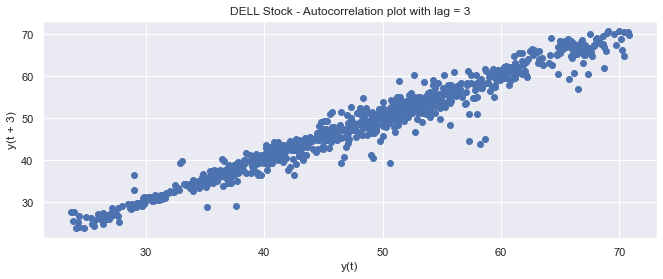

In [10]:
plt.figure()
lag_plot(df['Open'], lag=3)
plt.title('DELL Stock - Autocorrelation plot with lag = 3')
plt.show()

We can now confirm that ARIMA is going to be a good model to be applied to this type of data (there is auto-correlation in the data)

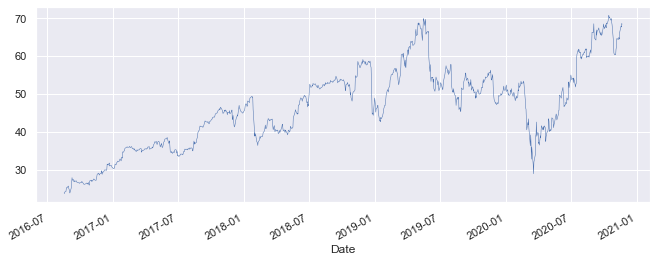

In [11]:
df['Close'].plot(linewidth=0.5);


Let’s check that if the given dataset is stationary or not, For that we use adfuller.

To identify the nature of data, we will be using the null hypothesis.

H0: The null hypothesis: It is a statement about the population that either is believed to be true or is used to put forth an argument unless it can be shown to be incorrect beyond a reasonable doubt.

H1: The alternative hypothesis: It is a claim about the population that is contradictory to H0 and what we conclude when we reject H0.

#Ho: It is non-stationary
#H1: It is stationary

In [12]:
from statsmodels.tsa.stattools import adfuller

In [13]:
test_result=adfuller(df['Close'])

In [14]:
def adfuller_test(close):
    result=adfuller(close)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")

adfuller_test(df['Close'])

ADF Test Statistic : -1.8771517917434555
p-value : 0.34288477538883133
#Lags Used : 2
Number of Observations : 1072
weak evidence against null hypothesis,indicating it is non-stationary 


After running the above code we will get P-value.

Here P-value is 0.34 which is greater than 0.05, which means data is accepting the null hypothesis, which means data is non-stationary.

Let’s try to see the first difference and seasonal difference:

In [15]:
df['Close First Difference'] = df['Close'] - df['Close'].shift(1)
df['Seasonal First Difference']=df['Close']-df['Close'].shift(12)
df.head()

,High,Low,Open,Close,Volume,Adj Close,Close First Difference,Seasonal First Difference
Date,,,,,,,,
2016-08-17,24.363234,23.809525,24.086378,23.809525,137600.0,23.809525,NaN,NaN
2016-08-18,24.363234,23.532669,24.363234,23.671097,895700.0,23.671097,-0.138428,NaN
2016-08-19,24.086378,23.615725,23.643412,24.086378,2400300.0,24.086378,0.415281,NaN
2016-08-22,25.249170,23.588039,23.809525,24.169436,1138300.0,24.169436,0.083057,NaN
2016-08-23,25.415283,24.086378,24.224806,24.916943,751600.0,24.916943,0.747507,NaN


In [16]:
# Again testing if data is stationary
adfuller_test(df['Seasonal First Difference'].dropna())

ADF Test Statistic : -6.81295548657285
p-value : 2.0935930818833394e-09
#Lags Used : 22
Number of Observations : 1040
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


Here P-value is 2.09, which means we will be rejecting the null hypothesis. So data is stationary.

<AxesSubplot:xlabel='Date'>

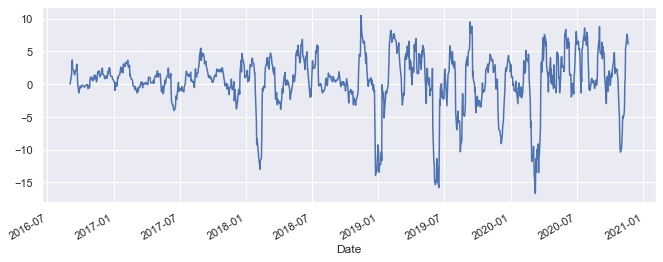

In [17]:
df['Seasonal First Difference'].plot()

Creating autocorrelation

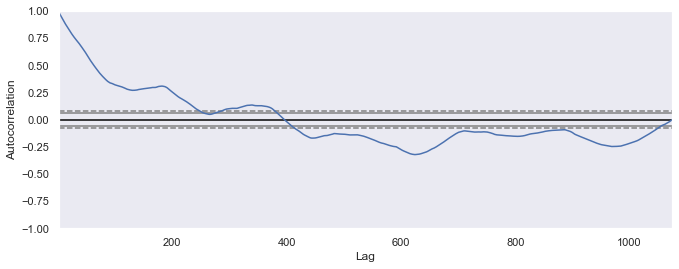

In [18]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['Close'])
plt.show()


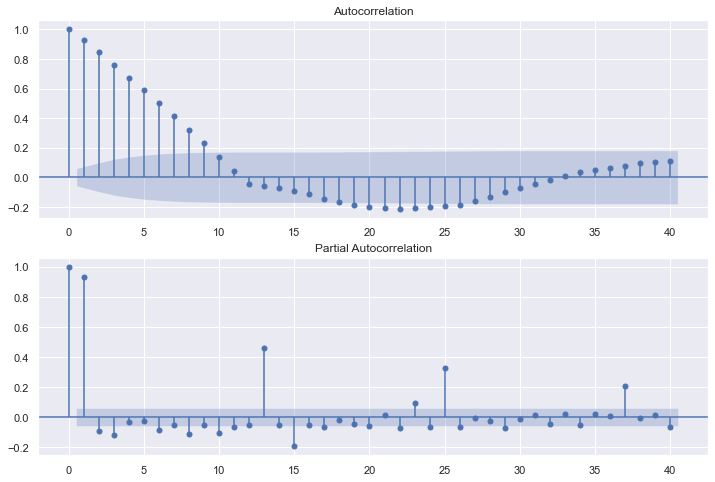

In [19]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Seasonal First Difference'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Seasonal First Difference'].dropna(),lags=40,ax=ax2)

Next, let’s divide the data into a training (70 % ) and test (30%) set

In [20]:
train_data, test_data = df[0:int(len(df)*0.7)], df[int(len(df)*0.7):]
training_data = train_data['Close'].values
test_data = test_data['Close'].values

In [21]:
history = [x for x in training_data]
model_predictions = []
N_test_observations = len(test_data)
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)
MSE_error = mean_squared_error(test_data, model_predictions)
print('Testing Mean Squared Error is {}'.format(MSE_error))

C:\Users\nagan\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\nagan\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.AR

Testing Mean Squared Error is 1.9060991295678231


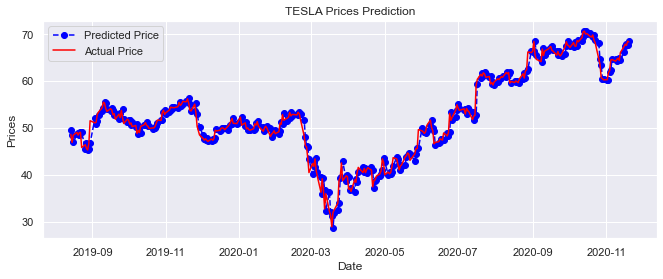

In [22]:
test_set_range = df[int(len(df)*0.7):].index
plt.plot(test_set_range, model_predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range, test_data, color='red', label='Actual Price')
plt.title('TESLA Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
#plt.xticks(np.arange(881,1259,50), df.Date[881:1259:50])
plt.legend()
plt.show()